KAGGLE - TITANIC

In [448]:
import warnings

import re

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report

import pickle

In [449]:
RANDOM_STATE = 42

In [450]:
# Useful functions
def feature_names(sklearn_feature_name_output, df):
    """
    This function takes the output from the .get_feature_names() method on the PolynomialFeatures 
    instance and replaces values with df column names to return output such as 'Col_1 x Col_2'

    sklearn_feature_name_output: The list object returned when calling .get_feature_names() on the PolynomialFeatures object
    df: Pandas dataframe with correct column names
    """
    cols = df.columns.tolist()
    feat_map = {'x'+str(num):cat for num, cat in enumerate(cols)}
    feat_string = ','.join(sklearn_feature_name_output)
    for k,v in feat_map.items():
        feat_string = re.sub(fr"\b{k}\b",v,feat_string)
    return feat_string.replace(" "," x ").split(',')

In [451]:
df = pd.read_csv('./DATA/train.csv')

In [452]:
df.shape

(891, 12)

In [453]:
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [454]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [455]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [456]:
features = ['Sex', 'Age', 'Pclass', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = ['Survived']

df = df[features+target]

In [457]:
df['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

In [406]:
df.head()

,Sex,Age,Pclass,SibSp,Parch,Fare,Embarked,Survived
0,male,22.0,3,1,0,7.2500,S,0
1,female,38.0,1,1,0,71.2833,C,1
2,female,26.0,3,0,0,7.9250,S,1
3,female,35.0,1,1,0,53.1000,S,1
4,male,35.0,3,0,0,8.0500,S,0


In [407]:
df.dtypes

Sex          object
Age         float64
Pclass        int64
SibSp         int64
Parch         int64
Fare        float64
Embarked     object
Survived      int64
dtype: object

In [408]:
df['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [409]:
# df['Cabin_0'] = df['Cabin'].apply(lambda x : str(x)[0])
# df['Cabin_0'].value_counts()

In [410]:
df['Embarked'] = df['Embarked'].fillna('S')

In [411]:
df.isnull().sum()

Sex           0
Age         177
Pclass        0
SibSp         0
Parch         0
Fare          0
Embarked      0
Survived      0
dtype: int64

In [412]:
cat_cols = ['Sex', 'Embarked', 'Pclass']
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']

In [413]:
X = df.drop('Survived', axis=1)
y = df['Survived']

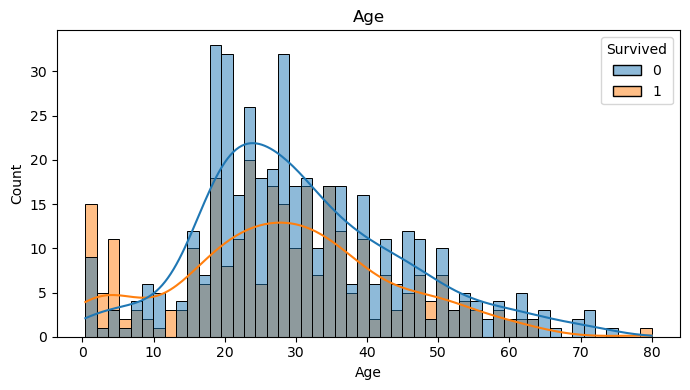

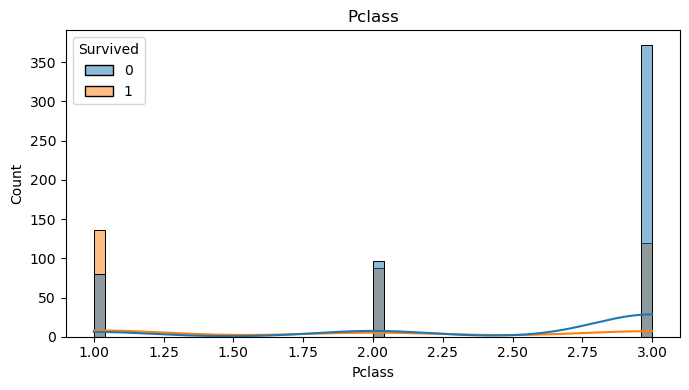

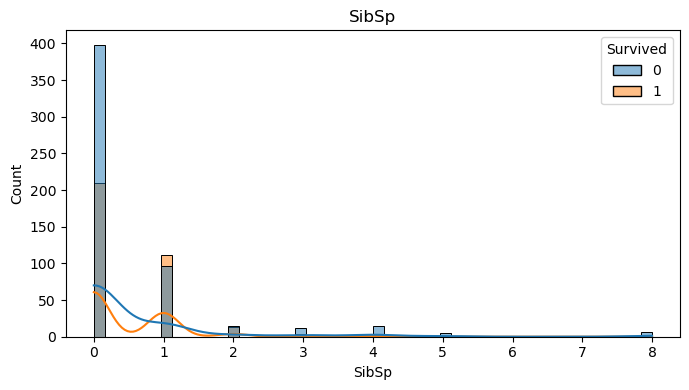

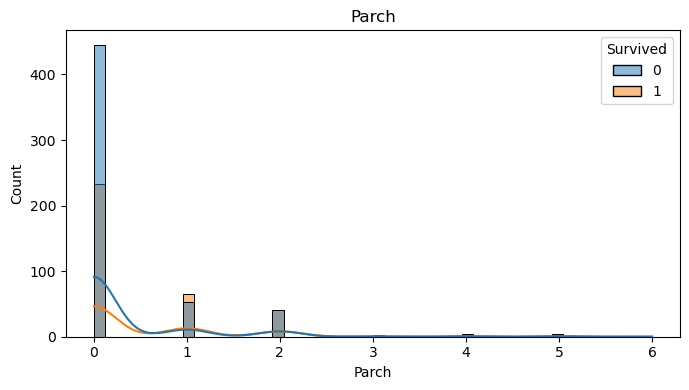

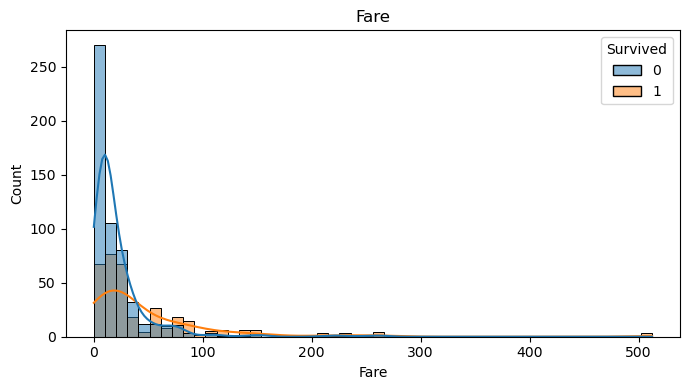

In [318]:
for x in num_cols:
    plt.figure(figsize=(7,4), dpi=100)
    sns.histplot(data=df, x=x, bins=50, kde=True, hue='Survived')
    plt.title(f"{x}")
    plt.tight_layout()

Text(0.5, 1.0, 'Correlation')

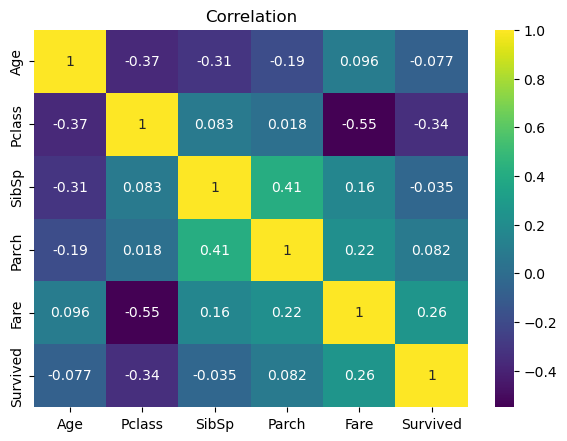

In [321]:
df_corr = df.corr()
plt.figure(figsize=(7,5), dpi=100)
sns.heatmap(data=df_corr, annot=True, cmap='viridis')
plt.title("Correlation")

<Figure size 1000x800 with 0 Axes>

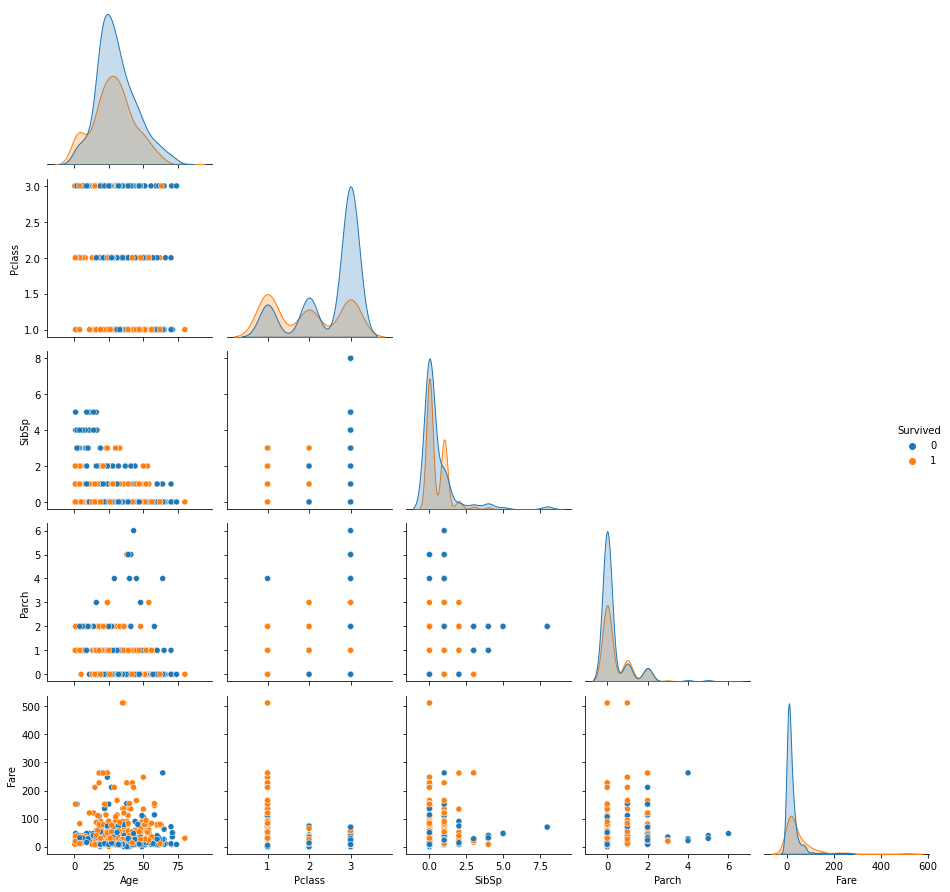

In [322]:
plt.figure(figsize=(10,8), dpi=100)
sns.pairplot(data = df, hue = "Survived", corner=True)
plt.tight_layout()

In [414]:
df.shape

(891, 8)

In [415]:
# Outliers
# df[(df.Fare > 500) | (df.Age > 75)]
df = df[(df.Fare <= 500) & ((df.Age <= 75) | df.Age.isnull())]

In [416]:
df.shape

(887, 8)

In [417]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
# X_train, y_train = X, y

In [418]:
X_train.shape, X_test.shape

((668, 7), (223, 7))

In [419]:
X_train.head()

,Sex,Age,Pclass,SibSp,Parch,Fare,Embarked
486,female,35.0,1,1,0,90.000,S
238,male,19.0,2,0,0,10.500,S
722,male,34.0,2,0,0,13.000,S
184,female,4.0,3,0,2,22.025,S
56,female,21.0,2,0,0,10.500,S


In [420]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,537.0,29.931881,14.455975,0.42,21.0000,29.0000,39.0,80.0000
Pclass,668.0,2.312874,0.831906,1.00,2.0000,3.0000,3.0,3.0000
SibSp,668.0,0.464072,0.999353,0.00,0.0000,0.0000,1.0,8.0000
Parch,668.0,0.375749,0.832877,0.00,0.0000,0.0000,0.0,6.0000
Fare,668.0,31.177469,47.457877,0.00,7.8958,13.8604,30.5,512.3292


In [421]:
# OH encoding
categorical_transformer = Pipeline(
    steps=[('OHencoder', OneHotEncoder(handle_unknown='ignore', sparse=False, drop = 'first'))
    ])

preprocessor_oh = ColumnTransformer(
    transformers=[('cat', categorical_transformer, cat_cols)],
    remainder='passthrough', 
    verbose_feature_names_out=False)

In [422]:
X_train_oh = pd.DataFrame(preprocessor_oh.fit_transform(X_train), columns = preprocessor_oh.get_feature_names_out())
X_test_oh = pd.DataFrame(preprocessor_oh.transform(X_test), columns = preprocessor_oh.get_feature_names_out())

In [423]:
X_train_oh.head()

,Sex_male,Embarked_Q,Embarked_S,Pclass_2,Pclass_3,Age,SibSp,Parch,Fare
0,0.0,0.0,1.0,0.0,0.0,35.0,1.0,0.0,90.000
1,1.0,0.0,1.0,1.0,0.0,19.0,0.0,0.0,10.500
2,1.0,0.0,1.0,1.0,0.0,34.0,0.0,0.0,13.000
3,0.0,0.0,1.0,0.0,1.0,4.0,0.0,2.0,22.025
4,0.0,0.0,1.0,1.0,0.0,21.0,0.0,0.0,10.500


In [424]:
X_train = X_train_oh
X_test = X_test_oh

X_train = X_train.set_index(y_train.index)
X_test = X_test.set_index(y_test.index)

In [425]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Sex_male,668.0,0.649701,0.477421,0.00,0.0000,1.0000,1.0,1.0000
Embarked_Q,668.0,0.080838,0.272791,0.00,0.0000,0.0000,0.0,1.0000
Embarked_S,668.0,0.720060,0.449306,0.00,0.0000,1.0000,1.0,1.0000
Pclass_2,668.0,0.211078,0.408379,0.00,0.0000,0.0000,0.0,1.0000
Pclass_3,668.0,0.550898,0.497775,0.00,0.0000,1.0000,1.0,1.0000
Age,537.0,29.931881,14.455975,0.42,21.0000,29.0000,39.0,80.0000
SibSp,668.0,0.464072,0.999353,0.00,0.0000,0.0000,1.0,8.0000
Parch,668.0,0.375749,0.832877,0.00,0.0000,0.0000,0.0,6.0000
Fare,668.0,31.177469,47.457877,0.00,7.8958,13.8604,30.5,512.3292


In [426]:
# Imputation
strat_nan_num='mean'
#strat_nan_num='median'

quant_transformer = Pipeline(
    steps=[('Imputer', SimpleImputer(strategy = strat_nan_num))]) 

preprocessor_imp = ColumnTransformer(
    transformers=[('quant', quant_transformer, num_cols),],
    remainder='passthrough', verbose_feature_names_out=False)

In [427]:
X_train[num_cols] = preprocessor_imp.fit_transform(X_train[num_cols])
X_test[num_cols] = preprocessor_imp.transform(X_test[num_cols])

In [428]:
# Scaling
scaler = StandardScaler()

scaler.fit(X_train[num_cols])

X_train[num_cols] = scaler.transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [429]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Sex_male,668.0,6.497006e-01,0.477421,0.000000,0.000000,1.000000,1.000000,1.000000
Embarked_Q,668.0,8.083832e-02,0.272791,0.000000,0.000000,0.000000,0.000000,1.000000
Embarked_S,668.0,7.200599e-01,0.449306,0.000000,0.000000,1.000000,1.000000,1.000000
Pclass_2,668.0,2.110778e-01,0.408379,0.000000,0.000000,0.000000,0.000000,1.000000
Pclass_3,668.0,5.508982e-01,0.497775,0.000000,0.000000,1.000000,1.000000,1.000000
Age,668.0,8.725555e-19,1.000749,-2.279058,-0.612540,0.000000,0.468611,3.866515
SibSp,668.0,1.030447e-17,1.000749,-0.464720,-0.464720,-0.464720,0.536677,7.546455
Parch,668.0,9.141058e-17,1.000749,-0.451483,-0.451483,-0.451483,-0.451483,6.757861
Fare,668.0,6.265780e-17,1.000749,-0.657443,-0.490943,-0.365167,-0.014286,10.146098


In [288]:
# Polynomial features
cat_cols_oh = [col for col in X_train.columns if col not in num_cols]

poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)

In [289]:
X_train_num_poly = pd.DataFrame(poly.fit_transform(X_train[num_cols]), 
                                columns = feature_names(poly.get_feature_names_out(), X_train[num_cols]))

X_test_num_poly = pd.DataFrame(poly.transform(X_test[num_cols]), 
                               columns = feature_names(poly.get_feature_names_out(), X_test[num_cols]))

In [290]:
X_train = pd.concat([X_train[cat_cols_oh].reset_index(drop=True), X_train_num_poly.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test[cat_cols_oh].reset_index(drop=True), X_test_num_poly.reset_index(drop=True)], axis=1)

In [291]:
X_train = X_train.set_index(y_train.index)
X_test = X_test.set_index(y_test.index)

In [430]:
X_train.head().T

,486,238,722,184,56
Sex_male,0.000000,1.000000,1.000000,0.000000,0.000000
Embarked_Q,0.000000,0.000000,0.000000,0.000000,0.000000
Embarked_S,1.000000,1.000000,1.000000,1.000000,1.000000
Pclass_2,0.000000,1.000000,1.000000,0.000000,1.000000
Pclass_3,0.000000,0.000000,0.000000,1.000000,0.000000
Age,0.391386,-0.844216,0.314161,-2.002592,-0.689765
SibSp,0.536677,-0.464720,-0.464720,-0.464720,-0.464720
Parch,-0.451483,-0.451483,-0.451483,1.951631,-0.451483
Fare,1.240397,-0.436028,-0.383310,-0.192999,-0.436028


In [386]:
X_train.to_pickle('./DATA/X_train.pkl')
y_train.to_pickle("./DATA/y_train.pkl")
X_test.to_pickle("./DATA/X_test.pkl")
y_test.to_pickle("./DATA/y_test.pkl")

HistGradientBoosting

In [ ]:
clf = HistGradientBoostingClassifier(random_state=RANDOM_STATE, max_iter=10000)

params = {'learning_rate' : [0.01, 0.1, 0.2],
          'l2_regularization' : [0, 0.01, 0.1, 0.2],
          "max_depth": [10, 15, 20]}

clf_grid = GridSearchCV(clf, 
                        param_grid = params,
                        verbose = 2)

clf_grid.fit(X_train, y_train)

In [72]:
clf_grid.best_estimator_.get_params()

{'categorical_features': None,
 'early_stopping': 'auto',
 'l2_regularization': 0,
 'learning_rate': 0.01,
 'loss': 'log_loss',
 'max_bins': 255,
 'max_depth': 10,
 'max_iter': 10000,
 'max_leaf_nodes': 31,
 'min_samples_leaf': 20,
 'monotonic_cst': None,
 'n_iter_no_change': 10,
 'random_state': 42,
 'scoring': 'loss',
 'tol': 1e-07,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [297]:
clf = HistGradientBoostingClassifier(loss = 'log_loss', 
                                     learning_rate = 0.01,
                                     l2_regularization = 0,
                                     max_depth = 10,
                                     random_state=RANDOM_STATE, max_iter=10000)
clf.fit(X_train, y_train)

HistGradientBoostingClassifier(l2_regularization=0, learning_rate=0.01,
                               max_depth=10, max_iter=10000, random_state=42)

In [298]:
y_pred = clf.predict(X_test)

In [299]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       137
           1       0.72      0.66      0.69        86

    accuracy                           0.77       223
   macro avg       0.76      0.75      0.75       223
weighted avg       0.77      0.77      0.77       223



Logistic regression

In [300]:
%%capture --no-display

clf = LogisticRegression(random_state=RANDOM_STATE, max_iter=10000)

params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
}

clf_grid = GridSearchCV(clf, 
                        param_grid = params,
                        scoring = 'balanced_accuracy',
                        verbose = 0)

clf_grid.fit(X_train, y_train)

GridSearchCV(estimator=LogisticRegression(max_iter=10000, random_state=42),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag',
                                    'saga']},
             scoring='balanced_accuracy')

In [302]:
clf_grid.best_estimator_.get_params()

{'C': 1,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 10000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'sag',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [303]:
clf = LogisticRegression(penalty = 'l2',
                         C = 1,
                         solver='sag', 
                         random_state=RANDOM_STATE, max_iter=10000)

clf.fit(X_train, y_train)

LogisticRegression(C=1, max_iter=10000, random_state=42, solver='sag')

In [304]:
y_pred = clf.predict(X_test)

In [305]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.84      0.82       137
           1       0.72      0.67      0.70        86

    accuracy                           0.78       223
   macro avg       0.76      0.76      0.76       223
weighted avg       0.77      0.78      0.77       223



GradientBoosting

In [431]:
clf = GradientBoostingClassifier(loss = 'deviance',
                                 learning_rate = 0.098,
                                 n_estimators = 460, 
                                 max_depth = 2, 
                                 min_samples_split = 9, 
                                 min_samples_leaf = 2,
                                 max_features = None,
                                 random_state = RANDOM_STATE)

clf.fit(X_train, y_train)

c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoostingClassifier(learning_rate=0.098, loss='deviance', max_depth=2,
                           min_samples_leaf=2, min_samples_split=9,
                           n_estimators=460, random_state=42)

In [432]:
y_pred = clf.predict(X_test)

In [433]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.90      0.85       137
           1       0.80      0.65      0.72        86

    accuracy                           0.80       223
   macro avg       0.80      0.77      0.78       223
weighted avg       0.80      0.80      0.80       223



Train on whole train data and export preprocessors and model

In [434]:
# OH
X_oh = pd.DataFrame(preprocessor_oh.fit_transform(X), columns = preprocessor_oh.get_feature_names_out())
X = X_oh
X = X.set_index(y.index)

# Imputation
X[num_cols] = preprocessor_imp.fit_transform(X[num_cols])

# Scaling
X[num_cols] = scaler.fit_transform(X[num_cols])

# Polynomial features

# Training
clf.fit(X, y)

c:\Users\danielgh\anaconda3\envs\env-01\lib\site-packages\sklearn\ensemble\_gb.py:310: FutureWarning: The loss parameter name 'deviance' was deprecated in v1.1 and will be removed in version 1.3. Use the new parameter name 'log_loss' which is equivalent.
  warnings.warn(


GradientBoostingClassifier(learning_rate=0.098, loss='deviance', max_depth=2,
                           min_samples_leaf=2, min_samples_split=9,
                           n_estimators=460, random_state=42)

In [435]:
filename = "OUTPUT/preprocessor_oh.pkl"
pickle.dump(preprocessor_oh, open(filename, 'wb'))

filename = "OUTPUT/preprocessor_imp.pkl"
pickle.dump(preprocessor_imp, open(filename, 'wb'))

filename = "OUTPUT/scaler.pkl"
pickle.dump(scaler, open(filename, 'wb'))

filename = "OUTPUT/clf.pkl"
pickle.dump(clf, open(filename, 'wb'))

Apply on test data

In [436]:
df = pd.read_csv('./DATA/test.csv')

In [437]:
cat_cols = ['Sex', 'Embarked', 'Pclass']
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
features = cat_cols + num_cols

X_test = df[features]

In [438]:
filename = "OUTPUT/preprocessor_oh.pkl"
preprocessor_oh = pickle.load(open(filename, 'rb'))

filename = "OUTPUT/preprocessor_imp.pkl"
preprocessor_imp = pickle.load(open(filename, 'rb'))

filename = "OUTPUT/scaler.pkl"
scaler = pickle.load(open(filename, 'rb'))

filename = "OUTPUT/clf.pkl"
clf = pickle.load(open(filename, 'rb'))

In [439]:
X_test_oh = pd.DataFrame(preprocessor_oh.transform(X_test), columns = preprocessor_oh.get_feature_names_out())
X_test = X_test_oh

In [443]:
X_test[num_cols] = preprocessor_imp.transform(X_test[num_cols])

In [444]:
X_test[num_cols] = scaler.transform(X_test[num_cols])

In [445]:
y_pred = clf.predict(X_test)

Export test predictions

In [446]:
output = pd.DataFrame({'PassengerId': df['PassengerId'], 'Survived': y_pred})
output.to_csv('OUTPUT/submission.csv', index=False)